c:\Users\ricca\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ricca\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\ricca\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ricca\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\ricca\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ricca\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\ricca\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ricca\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\User

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -0.14    |
|    exploration_rate | 0.005    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 4        |
|    time_elapsed     | 4        |
|    total_timesteps  | 20       |
| train/              |          |
|    learning_rate    | 0.1      |
|    loss             | 0.0021   |
|    n_updates        | 19       |
----------------------------------


c:\Users\ricca\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ricca\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


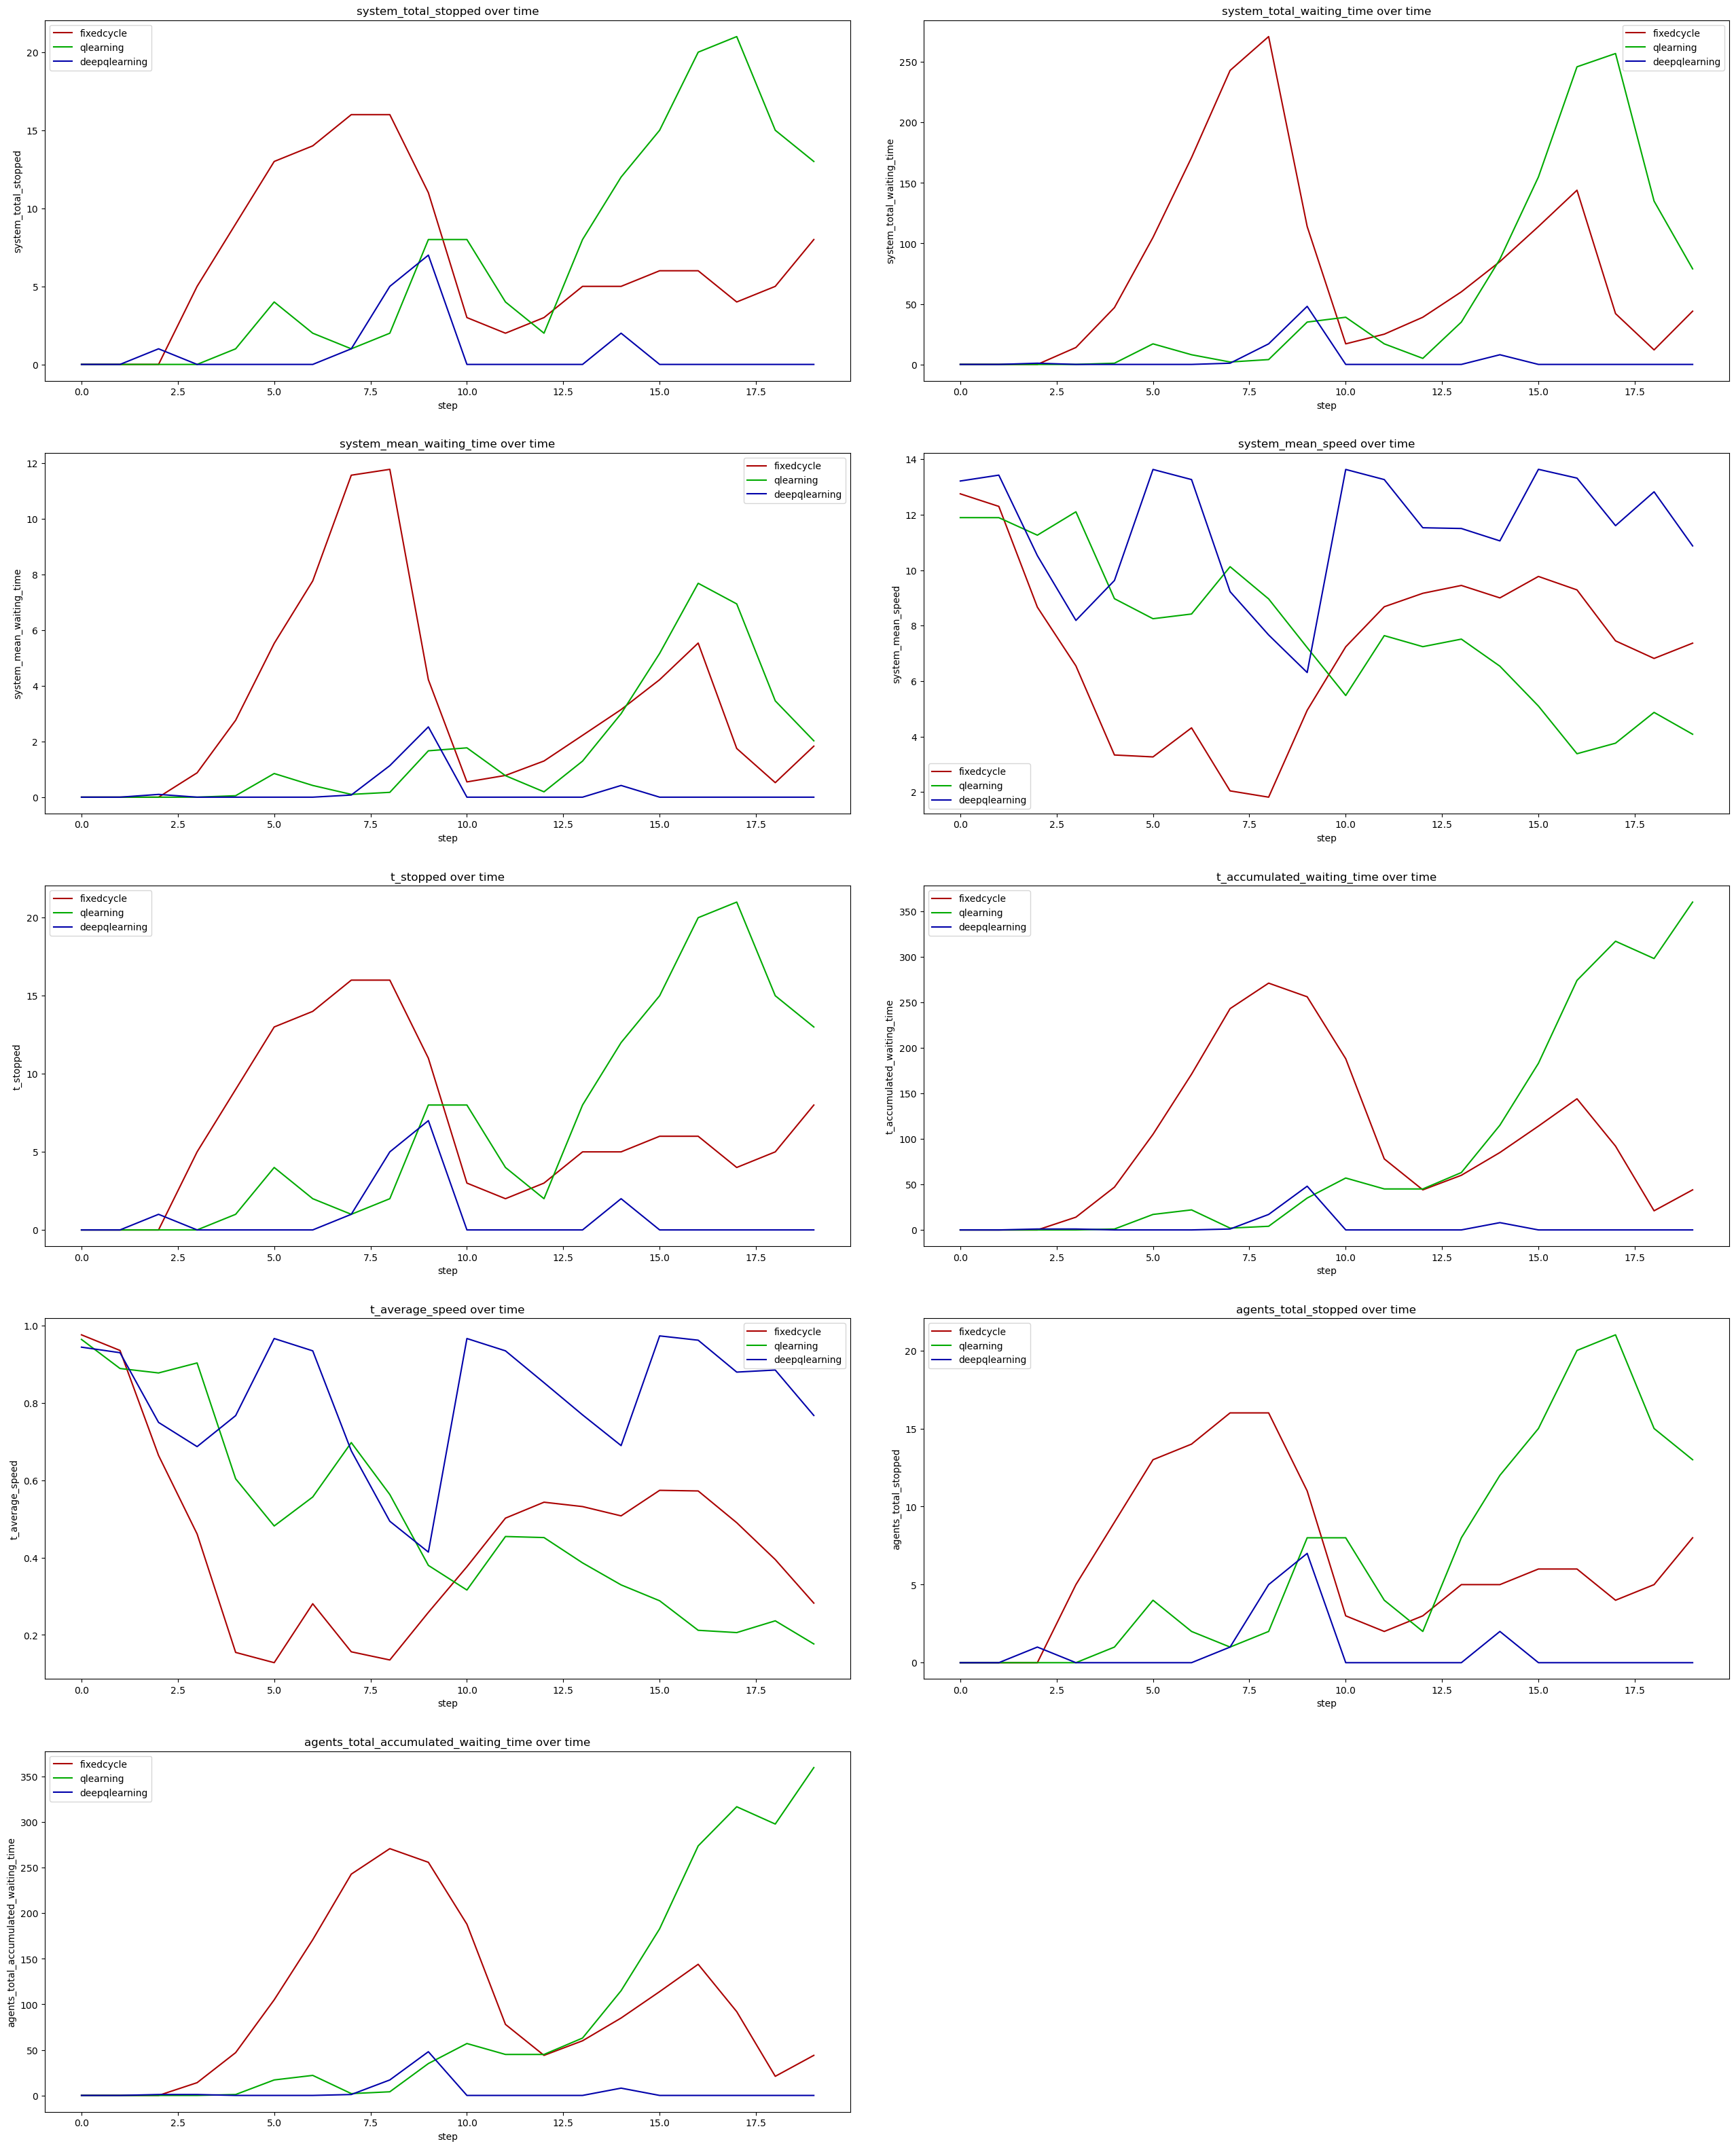

In [1]:
%matplotlib inline
from typing import Union, TypedDict, Literal
import pylab as pl
from IPython import display
from matplotlib.transforms import Bbox
from pathlib import Path
from agents.trafficagent import TrafficAgent, FixedCycleTrafficAgent, QLearningTrafficAgent, DeepQLearningTrafficAgent

class Plotter(TypedDict):
  plot: pl.Axes

# Metric = Union[TypedDict('Plotter', {'plot': pl.Axes}), dict[str, list[Union[int, float]]]]
Metric = Union[Plotter, dict[str, list[Union[int, float]]]]

seconds = 100

agents: dict[str, TrafficAgent] = {
  'fixedcycle': FixedCycleTrafficAgent(
    'fixedcycle',
    '#aa0000',
    'nets/single-intersection/single-intersection.net.xml',
    'nets/single-intersection/single-intersection.rou.xml',
    seconds,
    5,
    3,
    5,
    30
  ),
  'qlearning': QLearningTrafficAgent(
    'qlearning',
    '#00aa00',
    'nets/single-intersection/single-intersection.net.xml',
    'nets/single-intersection/single-intersection.rou.xml',
    seconds,
    5,
    3,
    5,
    30
  ),
  'deepqlearning': DeepQLearningTrafficAgent(
    'deepqlearning',
    '#0000aa',
    'nets/single-intersection/single-intersection.net.xml',
    'nets/single-intersection/single-intersection.rou.xml',
    seconds,
    5,
    3,
    5,
    30
  )
  # 'qlearning': {
  #   'color': '#0000aa',
  #   'fixed': False
  # # },
  # # 'fixedcycle': {
  # #   'color': '#aa0000',
  # #   'fixed': True
  # }
}
metrics: dict[str, Metric] = {
  # 'step': {},
  'system_total_stopped': {},
  'system_total_waiting_time': {},
  'system_mean_waiting_time': {},
  'system_mean_speed': {},
  't_stopped': {},
  't_accumulated_waiting_time': {},
  't_average_speed': {},
  'agents_total_stopped': {},
  'agents_total_accumulated_waiting_time': {}
}
num_metrics = len(metrics)

plots_row_length = num_metrics // 2 + num_metrics % 2
plots_col_length = 2 # Maybe be worth to increase/descrease depending on the amount of seconds
dpi = 100

figure = pl.figure()
figure.set_dpi(dpi)
figure.set_figheight(plots_row_length * 8)
figure.set_figwidth(min(max(seconds / 10, 32), (2**16 - 1) / dpi))
gridspec = figure.add_gridspec(plots_row_length, plots_col_length * 2)

for metric in metrics:
  metrics[metric] = { agent: [] for agent in agents }
  index = list(metrics.keys()).index(metric)
  col_index = index % 2 * 2
  metrics[metric]['plot'] = figure.add_subplot(gridspec[index // 2, col_index:(col_index + 2)])
  metrics[metric]['plot'].set_title(f'{metric} over time') # type: ignore
  metrics[metric]['plot'].set_xlabel('step') # type: ignore
  metrics[metric]['plot'].set_ylabel(metric) # type: ignore

def updateMetrics(name: str, info: dict[str, Union[int, float]]):
  for metric in metrics:
    metrics[metric][name].append(info[metric])
    # metrics[metric]['plot'].plot(metrics[metric][name], color=color)
  # display.clear_output(wait=True)
  # display.display(pl.gcf())

for agent in agents:
  agents[agent].learn(updateMetrics)
  # execution(updateMetrics, agent, seconds, agents[agent]['fixed'])

for metric in metrics:
  for agent in agents:
    metrics[metric]['plot'].plot(metrics[metric][agent], color = agents[agent].color)[0].set_label(agent) # type: ignore
    metrics[metric]['plot'].legend() # type: ignore
  bbox: Bbox = metrics[metric]['plot'].get_tightbbox(renderer = figure.canvas.get_renderer()) # type: ignore
  bbox = Bbox.from_extents(bbox.x0 / dpi, bbox.y0 / dpi, bbox.xmax / dpi, bbox.ymax / dpi)
  Path('outputs/plots/').mkdir(parents = True, exist_ok = True)
  pl.savefig(f'outputs/plots/{metric}_plot.png', bbox_inches = bbox.expanded(1.01, 1.01))

# pl.close(figure)